# Approach for correcting the 2020 images
The 2020 images were processed slightly differently, resulting in oversampled resolution and a vertical stretch factor. This can be corrected for via a linear formula. Pixel positions can be changed to stereographic coordinates by multiplication with pixel size and a reference position. To do this we need the top corner coordinates and the pixel size. The values for the pixel scale and for the image coordinates can be extracted from the images. For the X direction, we simply need the horizontal distance in meters, and the number of pixels. For the Y direction, there is an additional stretch term to remove an error from the image.

## Calculating parameters for transform
We first load a representative 2020 image and a reference image.

In [1]:
import rasterio as rio
import numpy as np
import proplot as pplt
from rasterio.plot import reshape_as_image

# Processed image with resampling and vertical stretch
shifted = rio.open('../../data/validation/Fram_Strait2020153.aqua.250m.tif')

# Reference image
correct = rio.open('../data/NE_Greenland.2017100.terra.250m.tif')

In [2]:
left1, bottom1, right1, top1 = shifted.bounds
left2, bottom2, right2, top2 = correct.bounds

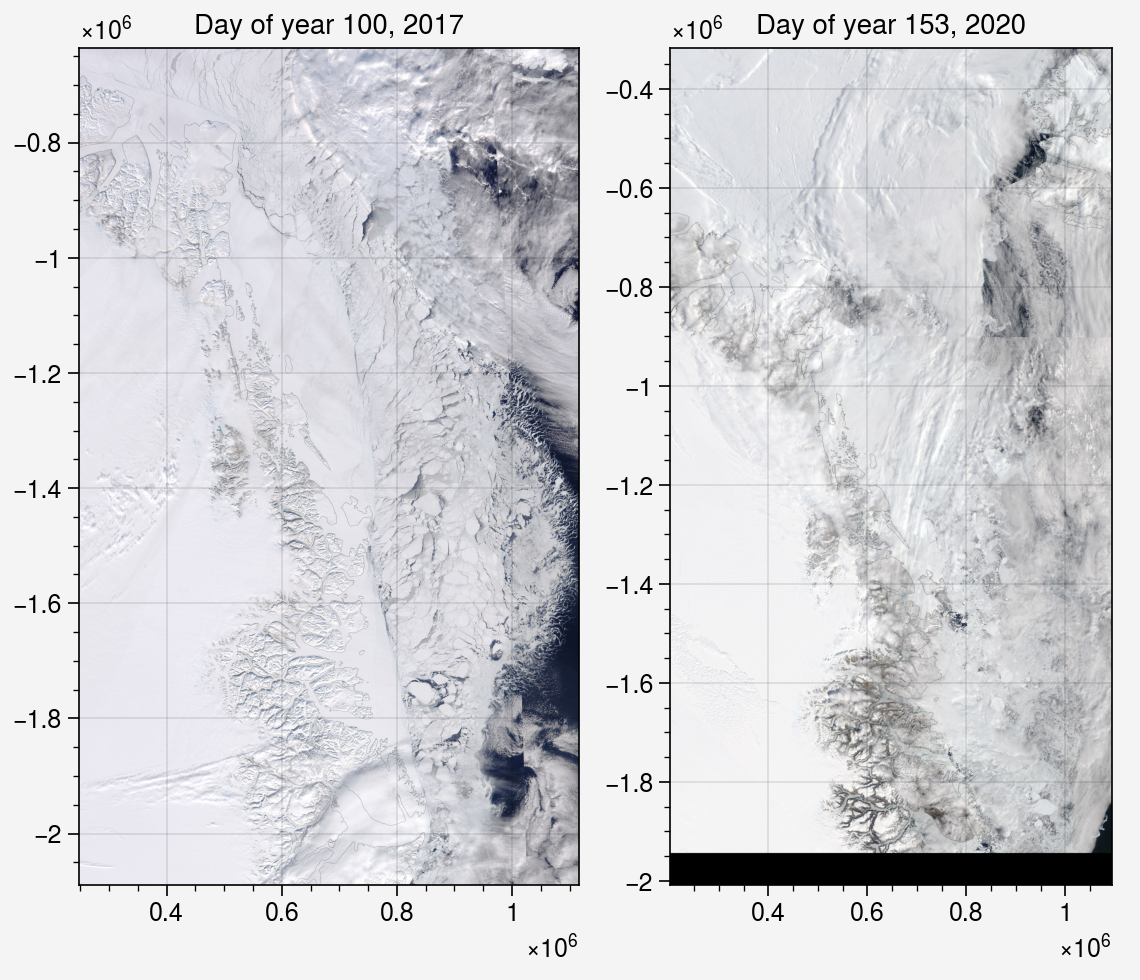

In [3]:
fig, ax = pplt.subplots(ncols=2, share=False)
ax[0].imshow(reshape_as_image(correct.read()), extent=[left2, right2, bottom2, top2])
ax[1].imshow(reshape_as_image(shifted.read()), extent=[left1, right1, bottom1, top1])
ax[0].format(title='Day of year 100, 2017')
ax[1].format(title='Day of year 153, 2020')

The image on the left is correct and has the shape that we are using for all the other images. On the right, we have the slightly different shape and a visible black bar at the bottom.

Calculating the horizontal pixel scale:

In [12]:
# 2017 image
dx2 = right2 - left2
dy2 = top2 - bottom2
ny2, nx2 = correct.shape
print('Correct image properties')
print('Horizontal pixel scale:', dx2/nx2, 'm')
print('Vertical pixel scale:', dy2/ny2, 'm')

Correct image properties
Horizontal pixel scale: 256.0 m
Vertical pixel scale: 256.0 m


For the 2020 image, we first get the horizontal scale in the same way

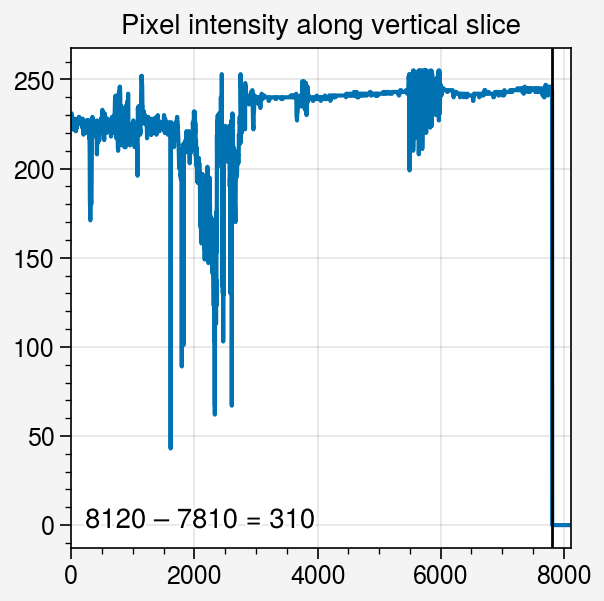

In [6]:
fig, ax = pplt.subplots()
b = shifted.read()[0,:,0]
ax.plot(b)
ax.axvline(np.argmin(b), color='k', lw=1)
ax.format(title='Pixel intensity along vertical slice',
          lltitle=str(shifted.shape[0]) + ' – ' + str(np.argmin(b)) + ' = ' + str(shifted.shape[0] - np.argmin(b)))

In [4]:
# 2020 image
dx1 = right1 - left1
ny1, nx1 = shifted.shape
print('2020 image properties')
print('Horizontal pixel scale:', np.round(dx1/nx1,3), 'm')

2020 image properties
Horizontal pixel scale: 200.298 m


The bottom 310 pixels have been set to zero. The remainder of the image was stretched to accomodate this gap. The likely cause was an attempt to overlay a mask, where instead of overlaying the mask the mask was appended and the image was automatically rescaled. We adjust simply by decreasing the number of rows in the image by the number of masked pixels in the calculation.

In [12]:
dy1 = top1 - bottom1
print('Vertical pixel scale:', np.round(dy1/(ny1 - 310),3), 'm')

Vertical pixel scale: 216.6 m


The left and top coordinates are from the image bounds:

In [14]:
print('Left bound:', np.round(left1, 1))
print('Top bound:', np.round(top1, 1))

Left bound: 200704.0
Top bound: -317440.0


## Correcting the centroid positions
The transform from pixels to stereographic coordinates is as follows:
```
info_region_pixel_scale_x = 200.298
info_region_pixel_scale_y = 216.600
left_x = 2.0070e5
top_y = -3.1744e5
df['x_stere'] = left_x + df['x_pixel'] * info_region_pixel_scale_x
df['y_stere'] = top_y - df['y_pixel'] * info_region_pixel_scale_y
```

## Correcting the shapes
Using the newly calculated parameters, we find a new shape for the floes in the floe library.
```
info_region_pixel_scale_x = 200.298
info_region_pixel_scale_y = 216.600
new_size = (int(floe_image.shape[0]*info_region_pixel_scale_y / 256), 
            int(floe_image.shape[1]*info_region_pixel_scale_x / 256))
```
From the difference in sizes between the old and new images, I calculate a size for a zero-pad around the image. I use the "resize" function in scikit image to use nearest neighbors interpolation to rescale the image, then use numpy to add a pad. Finally the image is pasted into the segmented image.